# Import libraries

In [14]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline

# MNIST preprocessing

In [91]:
# packing and unpacking images
def packcw(A,nr,nc):
    x = (A.T).reshape(nr*nc,1)
    return x

def unpackcw(x,nr,nc):
    A = x.reshape(nc,nr)
    return A.T

def packrw(A,nr,nc):
    x = A.reshape(nr*nc,1)
    return x

def unpackrw(x,nr,nc):
    A = x.reshape(nr,nc)
    return A

# generates a 784 element mask with columns deleted
# from the right side of the image towards the left
def generateColumnMask(delColumns):
    mask = np.ones((28, 28))
    mask[:, (28 - delColumns):] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# generate a 784 element mask with a square, with side
# length (sideLength), zero'd out of the middle
def generateCenterSquareMask(sideLength):
    mask = np.ones((28, 28))
    leftIdx = (28 - sideLength)/2
    rightIdx = (28 + sideLength)/2
    mask[leftIdx:rightIdx, leftIdx:rightIdx] = 0
    maskVec = packcw(mask, 28, 28)
    return maskVec

# zero out indices of a vector for a data matrix
# for a given mask
def hideData(data, mask):
    # copy the data
    newData = data.copy()
    
    # get indices from the mask
    x_idx = np.where([mask==1])[1]
    y_idx = np.where([mask==0])[1]
    
    # apply the mask
    newData[y_idx, :] = 0
    
    return newData, data[x_idx, :], data[y_idx, :]

# get statistics for mmse
def getStatistics(data, vectorMask):
    # get mean and covariance of original data
    mean = np.mean(data, axis=1)
    cov = np.cov(data)
    
    # get indices for X, Y parts of data
    x_idx = np.where([vectorMask == 0])[1]
    y_idx = np.where([vectorMask == 1])[1]
        
    # apply masks
    u_x = mean[x_idx]
    u_y = mean[y_idx]
    cov_x = cov[x_idx]
    cov_x = cov_x[:, x_idx]
    cov_yx = cov[y_idx]
    cov_yx = cov_yx[:, x_idx]
    cov_y = cov[y_idx]
    cov_y = cov_y[:, y_idx]
    
    # return statistics
    return u_x, u_y, cov_x, cov_yx

# let's get the data for halves
def returnHalfData(ncols):
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    train_hideRight, Xtrain_hideRight, Ytrain_hideRight = hideData(train, generateColumnMask(ncols))
    test_hideRight, Xtest_hideRight, Ytest_hideRight = hideData(test, generateColumnMask(ncols))

    return train_hideRight, Xtrain_hideRight, Ytrain_hideRight, test_hideRight, Xtest_hideRight, Ytest_hideRight

# let's get the data for halves
def returnSquareData(squareSideLength):
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle = hideData(train, generateCenterSquareMask(squareSideLength))
    test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle = hideData(test, generateCenterSquareMask(squareSideLength))

    return train_hideMiddle, Xtrain_hideMiddle, Ytrain_hideMiddle, test_hideMiddle, Xtest_hideMiddle, Ytest_hideMiddle

# let's get the data
def returnData():
    train = np.load('MNISTcwtrain1000.npy')
    train = train.astype(float)/255
    test = np.load('MNISTcwtest100.npy')
    test = test.astype(float)/255

    size = train.shape[0]
    n_train = train.shape[1]
    n_test = test.shape[1]

    print '----MNIST dataset loaded----'
    print 'Train data: %d x %d' %(size, n_train)
    print 'Test data: %d x %d' %(size, n_test)

    return train, test

In [16]:
# let's get our data
train, test = returnData()

----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000


----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000


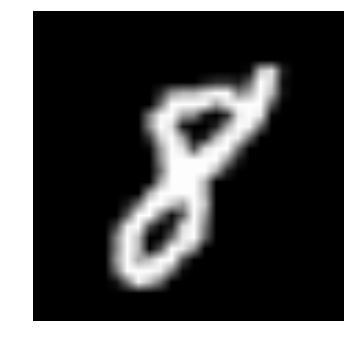

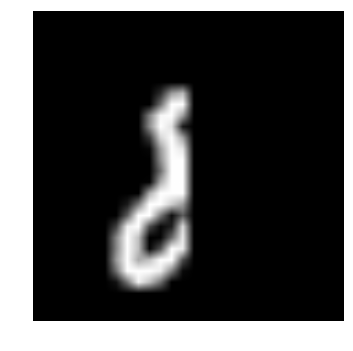

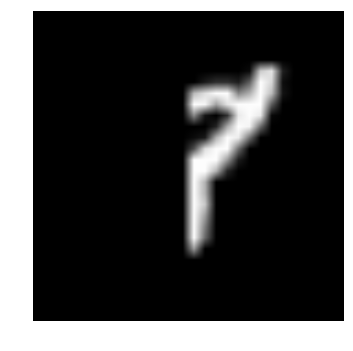

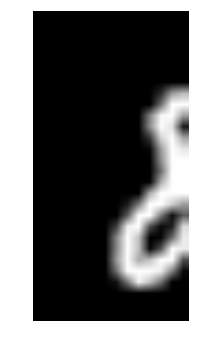

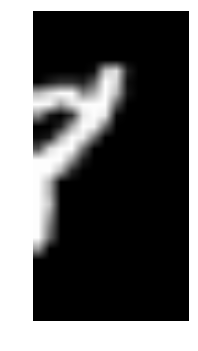

In [12]:
train_hideRight, Xtrain_hideRight, Ytrain_hideRight, \
test_hideRight, Xtest_hideRight, Ytest_hideRight = returnHalfData(14)

random = np.random.randint(0, 10000)
random = 8000
originalImg = unpackcw(train[:, random], 28, 28)
hiddenImg = unpackcw(train_hideRight[:, random], 28, 28)
hiddenVec = np.concatenate((np.zeros(28*14), Ytrain_hideRight[:, random]), axis = 0)
hiddenPart = unpackcw(hiddenVec, 28, 28)
justLeft = unpackcw(Xtrain_hideRight[:, random], 28, 14)
justRight = unpackcw(Ytrain_hideRight[:, random], 28, 14)

plt.figure(1)
plt.imshow(originalImg, cmap='gray'); plt.axis('off') #plt.title('original')
plt.savefig('Fig_original.png')
plt.figure(2)
plt.imshow(hiddenImg, cmap='gray'); plt.axis('off') #plt.title('hidden')
plt.savefig('Fig_hidden.png')
plt.figure(3)
plt.imshow(hiddenPart, cmap='gray'); plt.axis('off') #plt.title('hidden Y')
plt.figure(4)
plt.imshow(justLeft, cmap='gray'); plt.axis('off') #plt.title('just X')
plt.savefig('Fig_justLeft.png')
plt.figure(5)
plt.imshow(justRight, cmap='gray'); plt.axis('off') #plt.title('just Y')
plt.savefig('Fig_justRight.png')

----MNIST dataset loaded----
Train data: 784 x 10000
Test data: 784 x 1000


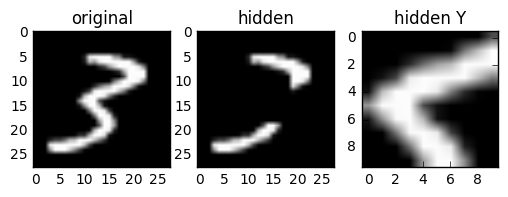

In [15]:
train_hideCenter, Xtrain_hideCenter, Ytrain_hideCenter, \
test_hideCenter, Xtest_hideCenter, Ytest_hideCenter = returnSquareData(10)

random = np.random.randint(0, 10000)
originalImg = unpackcw(train[:, random], 28, 28)
hiddenImg = unpackcw(train_hideCenter[:, random], 28, 28)
hiddenPart = unpackcw(Ytrain_hideCenter[:, random], 10, 10)

plt.figure(1)
plt.subplot(1, 3, 1); plt.imshow(originalImg, cmap='gray'); plt.title('original')
plt.subplot(1, 3, 2);  plt.imshow(hiddenImg, cmap='gray'); plt.title('hidden')
plt.subplot(1, 3, 3);  plt.imshow(hiddenPart, cmap='gray'); plt.title('hidden Y')